In [1]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma
import scipy.linalg as linalg
import statsmodels.api as sm
import os.path
import pickle

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# pd.set_option('max_rows', 20)
pd.set_option('max_rows', 100)

dataDetailsSheet = "Plan2"

In [2]:
utils = importr("MARSS")

# Data

## Regressors

In [3]:
data = pd.read_excel("Nowcasting.xlsx",sheetname="Valores")
# data.head()
series = data.loc[0,:][~data.loc[0,:].isnull()].tolist()
data.columns = data.iloc[0]

In [4]:
# i=data.columns.get_loc("MXWO Index")
# data.iloc[1:,i:i+2]

dfsList = []

for serie in series:
    i = data.columns.get_loc(serie)
    df = data.iloc[1:,i:i+2]
    df.set_index(serie,inplace=True)
    df.columns = [serie]
    df = df.loc[~df.index.duplicated(keep='first')]
    if not df[serie].isnull().all():
        dfsList.append(df.apply(pd.to_numeric))

data = pd.concat(dfsList,axis=1)
data.sort_index(inplace=True)
if data.loc[data.index[-1]].notnull().any() == False:
    data.drop(data.index[-1],inplace=True)
data.tail()

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1877: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


,BZGDINDX Index,BZGDGNDI Index,BZGDFNCE Index,BZIPTLYo Index,BZUETOTN Index,BFOETTOD Index,MPMIBRMA Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,...,BZEASA INDEX,OEBRD003 INDEX,BZGDYOY% Index,BZGDQOQ Index,BZIPTLSA Index,BRLFUNRT Index,BFOETTSA Index,BZPIIPCY Index,BZRTRETM Index,BZJCTOTS Index
2017-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.loc[data.index[-1]].notnull().any()

True

### Select Sample 

In [6]:
gdpTicker = "BZGDYOY% Index"
listOfCols = [
    "BZGDYOY% Index",
#     "BZGDGNDI Index",
#     "BZGDFNCE Index",
    "BZIPTLSA Index",
    "MPMIBRMA Index",
    "BFOETTSA Index",
    "BZREELHT Index",
    "BZPIIPCY Index",
    "BZPIIPCM Index",
    "BZEXTOT$ Index",
    "BZTBBALY INDEX",
    "BZBXPBCM INDEX",
    "BZRTFBSA INDEX",
    "BZFGCCSA INDEX",
    "ibov index",
    "CL1 Comdty",
    "BCSWLPD CURNCY",
    "bcswfpd curncy",
    "BZMOTRFB INDEX",
    "BZJCTOTS Index",
    "BZEASA INDEX",
    "OEBRD003 INDEX",
    "BZRTRETM Index",
]
data = data[listOfCols]

In [7]:
data.index.min()

Timestamp('2000-01-05 00:00:00')

In [8]:
data.index.max()

Timestamp('2017-03-20 00:00:00')

### Transformations


In [9]:
data.columns

Index(['BZGDYOY% Index', 'BZIPTLSA Index', 'MPMIBRMA Index', 'BFOETTSA Index',
       'BZREELHT Index', 'BZPIIPCY Index', 'BZPIIPCM Index', 'BZEXTOT$ Index',
       'BZTBBALY INDEX', 'BZBXPBCM INDEX', 'BZRTFBSA INDEX', 'BZFGCCSA INDEX',
       'ibov index', 'CL1 Comdty', 'BCSWLPD CURNCY', 'bcswfpd curncy',
       'BZMOTRFB INDEX', 'BZJCTOTS Index', 'BZEASA INDEX', 'OEBRD003 INDEX',
       'BZRTRETM Index'],
      dtype='object')

In [10]:
transf = pd.read_excel("Nowcasting.xlsx",sheetname=dataDetailsSheet,)
transf.set_index("Code",inplace=True)

In [11]:
for s in transf.index[transf["Log"]==True]:
    if s in data.columns:
        data[s] = data[s].apply(np.log)
    
data = data.resample("M").sum()
    
for s in transf.index[transf["Diff"]==True]:
    if s in data.columns:
        print(s)
        data[s] = data[s].diff()

for s in transf.index[transf["DiffAnnual"]==True]:
    if s in data.columns:
        data[s] = data[s].diff(3)

MPMIBRMA Index
BZREELHT Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZEASA INDEX
OEBRD003 INDEX
BZIPTLSA Index
BFOETTSA Index
BZPIIPCY Index
BZJCTOTS Index


C:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1251: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [12]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

### Standardize


In [13]:
mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

### Stationarity

In [14]:
# For now we'll drop quarterly series
# data.drop("BZGDGNDI Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("ibov index",axis=1,inplace=True)
# data.drop("CL1 Comdty",axis=1,inplace=True)
# data.drop("BCSWLPD CURNCY",axis=1,inplace=True)
# data.drop("bcswfpd curncy",axis=1,inplace=True)
# data.drop("BZEXTOT$ Index",axis=1,inplace=True)
# data.drop("BZTBBALY INDEX",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)

In [15]:
for series in data.columns:
    try:
        d = data[series]   
        print(series)
        pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
        if pv > 0.11:
            print(series + " 's p-value is: " + str(pv))
    except:
        print("Error")

BZGDYOY% Index
BZIPTLSA Index
MPMIBRMA Index
BFOETTSA Index
BZREELHT Index
BZPIIPCY Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
Error
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCTOTS Index
BZEASA INDEX
OEBRD003 INDEX
OEBRD003 INDEX 's p-value is: 0.41382820824
BZRTRETM Index


# Dimensions

In [16]:
dataQ = data[[gdpTicker]]
data.drop(gdpTicker,axis=1,inplace=True)

In [17]:
T = data.shape[0]
T

207

In [18]:
n = (data.columns | dataQ.columns).shape[0]
n

21

In [19]:
nm = (data.columns).shape[0]
nm

20

In [20]:
nq = (dataQ.columns).shape[0]
nq

1

In [21]:
m = 5 + nm + 5 * nq
m

30

# Data Matrices

$y$ which is $n \times T$ will be the vertical stack of the monthly and quarterly variables

In [22]:
y = pd.concat([ data.transpose(), dataQ.transpose(),], axis=0)
y.shape

(21, 207)

# Coefficients

## Z Matrix

The $Z$ matrix is a $n \times m$

In [23]:
coefs = []
for el in data.columns:
    coefs.append(el + "_loading")
lambdaM = pd.DataFrame(coefs)

line1 = lambdaM
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,4)))], axis=1)

line1 = pd.concat([line1, pd.DataFrame(np.identity(nm))], axis=1)
missingDimension = m - line1.shape[1]
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,missingDimension)))], axis=1)

line1.shape

(20, 30)

In [24]:
coefs = []
for el in dataQ.columns:
    coefs.append(el + "_loading")
lambdaQ = pd.DataFrame(coefs)

line2 = lambdaQ
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "3*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, lambdaQ], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.zeros((nq,nm)))], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 3*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)


In [25]:
line1.columns = list(range(0,line1.columns.shape[0]))
line2.columns = list(range(0,line2.columns.shape[0]))

Z = pd.concat([line1,line2], axis=0, ignore_index=True)
Z = Z.apply(pd.to_numeric,1,errors='ignore')
Z = Z.apply(pd.to_numeric,0,errors='ignore')
Z.shape

(21, 30)

In [26]:
# trying to impose restriction described in p 13-14 about identifying the model
Z.iloc[0,0] = 1
Z

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MPMIBRMA Index_loading,0,0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BFOETTSA Index_loading,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BZREELHT Index_loading,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BZPIIPCY Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BZPIIPCM Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,BZEXTOT$ Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BZTBBALY INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BZBXPBCM INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,BZRTFBSA INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## B Matrix

$B$ matrix is $m \times m$

In [27]:
bMat = np.array(["A1",0.,0.,0.])
bMat = np.vstack((np.array(bMat),np.identity(4)))
bMat = linalg.block_diag(bMat,np.array([0]))

alphaM = "alphaM_" + pd.DataFrame(data.columns.tolist()).astype(str) 
# alphaM = alphaM.transpose()[0]
alphaM = np.diag(alphaM[0])

bMat = bMat[:-1]

bMat = linalg.block_diag(bMat,alphaM)

alphaQ = "alphaQ_" + pd.DataFrame(dataQ.columns.tolist()).astype(str) 
# alphaQ = alphaQ.transpose()[0]
alphaQ = np.diag(alphaQ[0])

bMat = linalg.block_diag(bMat,alphaQ)

newLine = np.hstack((np.zeros((nq,bMat.shape[1]-nq)),np.identity(nq)))
bMat = np.vstack((bMat,newLine))

bMat = linalg.block_diag(bMat,np.identity(m-bMat.shape[1]-1))
bMat = linalg.block_diag(bMat,np.array([0]))
bMat = bMat[:-1]
B = pd.DataFrame(bMat)
B = B.apply(pd.to_numeric,1,errors='ignore')
B = B.apply(pd.to_numeric,0,errors='ignore')
# alphaM
# newLine
# pd.to_numeric(pd.DataFrame(bMat)[0].iloc[1])
B.shape

(30, 30)

## Q Matrix

$Q_t$ is $m \times m$


In [28]:
u = np.array("u_t")
u = np.vstack((u,np.zeros((4,1))))
merrors = "em_" + pd.DataFrame(np.array([list(range(0,nm))])).astype(str)
u = np.vstack((u,merrors.T))

merrors = "eq_" + pd.DataFrame(np.array([list(range(0,nq))])).astype(str)
u = np.vstack((u,merrors.T))

u = np.vstack((u,np.zeros((m-u.shape[0],1))))

u = pd.DataFrame(u)

u[0] = pd.to_numeric(u[0],errors='ignore')

idx = np.unique(np.where(u=="0.0" )[0].tolist() + np.where(u==0 )[0].tolist())

In [29]:
Q = "Q_" + pd.DataFrame([range(0,m)]).astype(str) 
Q = Q.transpose()[0]
Q = np.diag(Q)
Q[idx] = 0
Q = pd.DataFrame(Q)
Q.shape

(30, 30)

In [30]:
Q

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,Q_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,Q_5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,Q_6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,Q_7,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,Q_8,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,Q_9,...,0,0,0,0,0,0,0,0,0,0


# Estimation without initial values

In [31]:
Zi = Z.as_matrix().T.flatten()
Bi = B.as_matrix().T.flatten()
Qi = Q.as_matrix().T.flatten()
yi = y.as_matrix()

In [32]:
B.shape

(30, 30)

In [33]:
Z.shape

(21, 30)

In [34]:
y.shape

(21, 207)

In [35]:
Q.shape

(30, 30)

In [36]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n

# print(dim(Zi))
# Zi=matrix(Zi,n,m)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)

# print(dim(Zi))
# print(dim(Bi))
# print(dim(Qi))


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

# kemfit = MARSS(yi, model=model.gen,control=list(minit=1,maxit=2,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
# # kemfit = MARSS(yi, model=model.gen)

# # states = kemfit$states
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")

In [37]:
print(dt.datetime.now())

2017-03-24 10:32:54.559489


# Initial Values

## PCA

In [38]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(y.transpose().fillna(0))
components = pd.DataFrame(components)
# components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.23743172]


In [39]:
components.set_index(y.transpose().index,inplace=True)
components.shape

(207, 1)

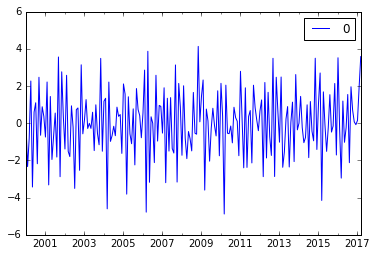

In [40]:
pd.DataFrame(components).plot()

## OLS for $\Lambda$ estimation

In [41]:
data.head()

,BZIPTLSA Index,MPMIBRMA Index,BFOETTSA Index,BZREELHT Index,BZPIIPCY Index,BZPIIPCM Index,BZEXTOT$ Index,BZTBBALY INDEX,BZBXPBCM INDEX,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCTOTS Index,BZEASA INDEX,OEBRD003 INDEX,BZRTRETM Index
2000-01-31,NaN,NaN,NaN,NaN,NaN,0.436592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,-1.722609,-1.510498,1.327472,NaN,NaN,0.390218,NaN,1.411873,0.972554,NaN,0.975459,NaN,NaN,NaN,0.877678,0.758013
2000-03-31,NaN,NaN,NaN,NaN,-1.852841,-0.854781,0.575209,NaN,NaN,-0.140217,NaN,0.018289,1.251490,NaN,-0.221743,NaN,NaN,NaN,0.864601,0.396529
2000-04-30,NaN,NaN,NaN,NaN,-0.281467,-0.048833,-0.578823,NaN,NaN,-1.704449,NaN,-1.021657,-1.955820,NaN,-1.030243,NaN,NaN,NaN,-0.607665,NaN
2000-05-31,NaN,NaN,NaN,NaN,-0.630297,-4.707422,1.434403,1.128881,NaN,1.157650,NaN,1.276000,1.466675,NaN,2.208863,NaN,NaN,NaN,0.531890,0.396529


In [42]:
def cleanData(df1,df2):
    df = pd.concat([df1, df2],axis=1)
    return df.dropna(axis=0)

In [43]:
coefList = []
for s in data.columns:
    print(s)
    clean = cleanData(data[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])
for s in dataQ.columns:
    clean = cleanData(dataQ[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])    

BZIPTLSA Index
MPMIBRMA Index
BFOETTSA Index
BZREELHT Index
BZPIIPCY Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCTOTS Index
BZEASA INDEX
OEBRD003 INDEX
BZRTRETM Index


In [44]:
lambda0 = pd.DataFrame(coefList)

## AR for $A$ estimation

In [45]:
A0 = coefList.append(sm.tsa.ARMA(components.dropna(),(1,0)).fit().params[1])


In [46]:
# Z0 = Z
# Z0[0] = lambda0
# Z0.iloc[-1,1] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,2] = 3 * Z0.iloc[-1,0]
# Z0.iloc[-1,3] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,4] = 1 * Z0.iloc[-1,0]

# Z0 = Z0.apply(pd.to_numeric,axis=1)
# Z0 = Z0.apply(pd.to_numeric,axis=0)

# Estimation With Initial Values

In [47]:
#  Spent a lot of time struggling here. 
# the size of the Z0 is actually the size of the non fixed parameters
Z0 = lambda0
Z0 = Z0.apply(pd.to_numeric,axis=1)
Z0 = Z0.apply(pd.to_numeric,axis=0)

# Next two lines are only useful when the restriction is effective
Z0 = Z0 * (1/Z0.iloc[0,0]) 
Z0.drop(0,axis=0,inplace=True)

Z0

,0
1,-54.449907
2,40.960934
3,-77.504340
4,-3.651558
5,-35.799346
6,248.534443
7,58.355698
8,147.464217
9,20.777235
10,-44.870197


In [48]:
x0i = np.zeros((m,1))
x0i[0,0] = components[0][0]
x0i = pd.DataFrame(x0i)
x0i

,0
0,0.024735
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [49]:
Z0i = Z0.as_matrix().T.flatten()

In [50]:
x0i = x0i.as_matrix().flatten()

In [51]:
def runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,maxit):
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
prediction = predict(kemfit,n.ahead=10,se.fit=FALSE)
print(attributes(prediction))

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
#     dic = {}
#     dic[]'vintage'} = yi
    return robjects.r.prediction

In [52]:
# pred = runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,5)

In [53]:
# robjects.r['states1']
# robjects.r('attributes(prediction)')

In [54]:
# robjects.r('print(prediction$method)')

In [55]:
print(dt.datetime.now())

2017-03-24 10:32:55.256867


In [56]:
# iters = [20,50,100,150,300,500,1000]
# # iters = [20,50,100,150]
# # iters = [20,50,100]
# stateslist = []
# for i in iters:
#     stateslist.append(runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,i))
#     print("done {maxiters}".format(maxiters=i))
#     print(dt.datetime.now())

In [57]:
print(dt.datetime.now())

2017-03-24 10:32:55.274915


* x0 - Done
* normalizar as séries antes - fazer o check. data.mean e etc
* Initial MC - Bug

In [58]:
# finalList = []
# for state in stateslist: 
#     finalList.append(pd.DataFrame(state).T)
# # stateslist[0]

## Check convergence

In [59]:
def runModel2(Zi,Bi,Qi,y,n,m,Z0i,x0i,maxit):
    yi = y.T.as_matrix()
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
states2 = kemfit$ytT
kfit = print(kemfit)

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
    dic = {}
    dic['vintage' ]= y
    dic['states'] = pd.DataFrame(robjects.r.states1).T
    dic['prediction'] = pd.DataFrame(robjects.r('print(kemfit,what=\'ytT\')')).T
    dic['prediction'].index = y.index
    dic['prediction'].columns = y.columns
    dic['message'] = robjects.r.kfit
    return dic

In [60]:
# listOfIters = [3, 5, 10, 30, 50, 100, 150,500,1000]
# # For Each pubdate
# listOfResultsConv = {}
# for iterN in listOfIters:
#     listOfResultsConv[iterN] = runModel2(Zi,Bi,Qi,y.T,n,m,Z0i,x0i,iterN)
    
# pickle.dump(listOfResultsConv, open(".\\Pickles\\Convergence.pickle", "wb"))

In [61]:
# ((listOfResultsConv[100]['states'].T.loc[0]) - (listOfResultsConv[150]['states'].T.loc[0])).hist()

In [62]:
# ((listOfResultsConv[100]['states'].T.loc[0]) - (listOfResultsConv[150]['states'].T.loc[0])).describe()

In [63]:
# (listOfResultsConv[150]['states'].T.loc[0]).describe()

## Stylised Calendar

In [64]:
yn = y.T
calendar = pd.read_excel("Nowcasting.xlsx",sheetname=dataDetailsSheet)
calendar = calendar[["Code","PubLag"]]
calendar.set_index("Code",inplace=True)

In [65]:
# Goal Create publicationDates as another index on the DF

newDfs = []

# For each Series
for serie in yn.columns:
#     Create new df
    newDf = pd.DataFrame(yn[serie])
    newDf.reset_index(inplace=True)
    cols = list(newDf.columns)
    cols[0] = "refDate"
    newDf.columns = cols
    newDf["pubDate"] = newDf["refDate"] + dt.timedelta(int(calendar.loc[serie]))
    newDf.set_index(["refDate","pubDate"],inplace=True)
    newDfs.append(newDf)

yn = pd.concat(newDfs,axis=1)
yn = yn.groupby(level="refDate").fillna(method='ffill')

In [66]:
# Goal: create stylised calendar for all info
pubDates = yn.index.get_level_values("pubDate").unique().sort_values()

In [67]:
np.where(pubDates==dt.datetime(2014,5,1))

(array([1720], dtype=int64),)

# Loop !

In [68]:
maxiter = 300

In [69]:
print(dt.datetime.now())

2017-03-24 10:32:57.551707


In [70]:
def loadDf(pubDate):
    filename = ".\\Pickles\\" + pubDate.strftime('%Y-%m-%d') + ".pickle"
    return pickle.load(open(filename, "rb"))

In [142]:
# For Each pubdate
listOfResults = {}
for pubDate in pubDates[5:]:
    print(pubDate)
    cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
    cutY = cutY.reindex(y.T.index)
    filename = ".\\Pickles\\" + pubDate.strftime('%Y-%m-%d') + ".pickle"
    if os.path.exists(filename):
#         print("Exists")
        listOfResults[pubDate] = pickle.load(open(filename, "rb"))
#         print("Loaded")
    else:
        print(pubDate)
#         print("Does not exist")
        listOfResults[pubDate] = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)
#         listOfResults[pubDate].to_pickle(filename)
        pickle.dump(listOfResults[pubDate], open(filename, "wb"))
#         print("Dumped")
#     print("Loop Finished")
    
# Still have to find a way to locate everytime a given series enters the dataset    

In [71]:
print(dt.datetime.now())

2017-03-24 10:33:20.416626


Notes:
   
* BCB reports YoY so we have to analise YoY

# Charts

## RMSFE chart

We'll get GDP dates and infer from ``listOfResults``'s keys which vintage corresponds to -X from the GDP pubDate 

So if I want -9, for each GDP published I'll find the -9 vintage and calculate the prediction error

In [72]:
#  Find GDP's publication dates
gdp = yn[gdpTicker]
# .groupby(level="refDate",group_keys=True).last()

gdp = gdp[~gdp.isnull()]

gdpDates = gdp.index.get_level_values("refDate")
# gdpDates

In [73]:
# vintages = pd.Series(list(listOfResults.keys())).sort_values().reset_index(drop=True)
vintages = pubDates[5:]
# vintages

In [74]:
# vintagesOfInterest = {}
# vintagesOfInterest[pubDates[8]]= vintages[(vintages - pubDates[8])<= dt.timedelta(-9)].max()


In [94]:
listOfAxis = [-30, -20, -10, 0, 10, 20, 30]
listOfAxis = range(-70,70)
# listOfAxis = [-30]
# listOfAxis = np.arange(-70,70,10).tolist()

In [95]:
rmsfe = {}

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    for gdpDate in gdpDates[5:]:
        vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
        actualGdp = gdp.groupby(level="refDate").last()
        actualGdp = actualGdp.loc[gdpDate]
        
        # Loaded Version
#         forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction'][gdpTicker]
        #Load Version
        forecast = loadDf(vintagesOfInterest[gdpDate])['prediction'][gdpTicker]
        
        forecast = forecast.loc[gdpDate]
        tempList.append((forecast-actualGdp)**2)
    rmsfe[sieve] = tempList

#     rmsfe[sieve] = 

rmsfe = pd.DataFrame(rmsfe).T

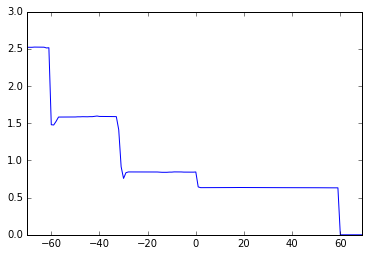

In [96]:
rmsfe.mean(axis=1).plot()

## Actual vs Prediction chart

In [97]:
actual = gdp.groupby(level="refDate").last()

In [98]:
# at 0 date
sieve = 59
vintagesOfInterest = {}
tempDir = {}
for gdpDate in gdpDates[5:]:
    vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
    # Loaded Version
#     forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction'][gdpTicker]
    # Load version
    forecast = loadDf(vintagesOfInterest[gdpDate])['prediction'][gdpTicker]
    
    forecast = forecast.loc[gdpDate]
    
    tempDir[gdpDate] = forecast

predict = pd.Series(tempDir)


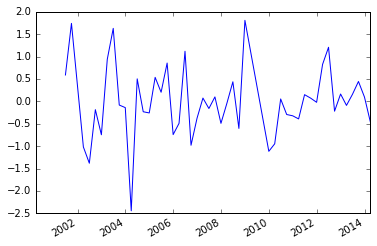

In [99]:
(predict-actual).plot()

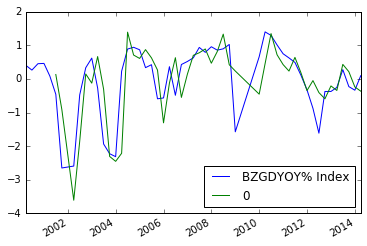

In [100]:
(pd.concat([actual,predict],axis=1)).plot()

In [2]:
vintagesOfInterest[dt.datetime(2016,11,29)]

NameError: name 'vintagesOfInterest' is not defined

In [3]:
listOfResults[vintagesOfInterest[dt.datetime(2016,11,29)]]['prediction']

NameError: name 'listOfResults' is not defined

In [ ]:
# WHAT WE WILL DO: Always pass a full calendar (even if full of NaNs) 
# and NaN everything after the cut calendar
pubDate = pubDates[1000]
cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
cutY = cutY.reindex(y.T.index)
tr = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)


In [ ]:
tr['prediction'].columns

In [ ]:
gdpPred = tr['prediction'][gdpTicker]
gdp = yn.groupby(level="refDate").last()[gdpTicker]

gdpPred = gdpPred[~gdp.isnull()]
gdp = gdp[~gdp.isnull()]

In [ ]:
(gdpPred-gdp)

In [ ]:
(tr['prediction'][gdpTicker] - yn.groupby(level="refDate").last()[gdpTicker]).plot()

In [ ]:
x = robjects.r('print(kemfit,what=\'ytT\')')

In [ ]:
pd.DataFrame(x).T.plot()

In [ ]:
y.T.shape

In [ ]:
robjects.r['states2']

In [ ]:
ls[0]

In [ ]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n,Z0i,x0i -o states,states1


# Zi=matrix(Zi,n,m)
# x0i=matrix(x0i,m,1)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)


# # Z0i=matrix(Z0i,n,1)
# Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

# # print(dim(Z0i))
# # print(dim(Zi))
# # print(dim(Bi))
# # print(dim(Qi))
# # print(x0i)

# print("START")

# # model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero"
# #                ,U="zero"
# #                ,R="diagonal and unequal")


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
#                ,x0=x0i
# #                ,x0="zero"
#                ,U="zero"
#                ,R="diagonal and equal")


# inits = list(Z=Z0i,x0=0)
# # print(Z0i)
# # print(Zi)
# # kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
# #                                                 conv.test.slope.tol=0.00001,
# #                                                 abstol=0.00001))
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=300
# #                                                 conv.test.slope.tol=0.3
# #                                                 abstol=0.5, 
# #                                                 allow.degen=TRUE
# #                                                 MCInit=TRUE,
# #                                                 numInits=100,
# #                                                 numInitSteps=20
#                                                            ))
# # kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=30))
# # kemfit = MARSS(yi, model=model.gen,inits=inits,fit=TRUE)
# # kemfit = MARSS(yi, model=model.gen,fit=FALSE)

# # print(kemfit$par$Z)
# states1 = kemfit$states
# states = print(kemfit)
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")